# Run NetConf on Houston IEEE data

In [2]:
# Import helper functions
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import helper_functions as hf
import imports as ip
import netconf.netconf as nc

In [3]:
# Polygon coordinates
x1, x2, y1, y2 = 3290100, 3290200, 272900, 273000

# Data files
labelFile = './data/2018IEEE_Contest/Phase2/TrainingGT/2018_IEEE_GRSS_DFC_GT_TR.tif'
hsFile = './data/2018IEEE_Contest/Phase2/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix'
radarFile = './data/2018IEEE_Contest/Phase2/Lidar GeoTiff Rasters/Intensity_C3/UH17_GI3F051.tif'

# A priori beliefs - 2 classes green/built
decisions = {0: False, 1: True}
initBeliefs, confidence = [0.5,0.5], [0,1] # [green, built], probability of being built

# Edge creation
adjacent, geoNeighbours, phase, neighbours = False, 2, True, 3

# Classifications
targets = ['Green', 'Built']

In [28]:
import pandas as pd
def raster_to_df(file, value='class', single = True, crop = False):
    arr = ip.raster_to_array(file, crop)
    if single: df = pd.DataFrame(arr[0]).stack().rename_axis(['y', 'x']).reset_index(name=value).set_index(['y','x'])
    else: 
        arr = 
        df = pd.DataFrame(arr.reshape(len(arr),-1)).stack().rename_axis(['y', 'x']).reset_index(name=value).set_index(['y','x'])
    return df, arr

In [ ]:
import pandas as pd
#arr = ip.raster_to_array(hsFile, crop=True)
pd.DataFrame(arr.reshape(len(arr),-1)).stack()
#pd.DataFrame(arr.reshape(len(arr),-1)).stack().rename_axis(['y', 'x']).reset_index(name=value).set_index(['y','x'])

In [ ]:
# Import rasters
#labels, larr = ip.raster_to_df(labelFile)
hs, hsarr = raster_to_df(hsFile, value='amp', single=False, crop=True)
#radar, radararr = ip.raster_to_df(radarFile, value='phase', crop=True)

# Plot values
fig, axs = hf.create_subplots(3,1,[10,7])
axs[0].imshow(larr[0])
axs[1].imshow(hsarr[0])
axs[2].imshow(radararr[0])
fig.tight_layout()

In [5]:
# Get geodatabase of every
initial = hf.init_beliefs(hs[:10000], columns=['green','built','amp'], crs='EPSG:6577')

geoLabels = hf.df_to_gdf(labels[:10000], columns=['class'], crs='EPSG:6577', reIndex=True)
geoLabels['class'] = hf.group_classes(geoLabels['class'], classes = [[1,7],[8,20]], zeroNan = True)

X_train, X_test, y_train, y_test = hf.train_test_split(geoLabels, column = 'class')

nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, decisions, confidence, column = 'class', beliefColumns = ['green', 'built'])

# Create edges
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=['amp'] if phase else False, neighbours=[neighbours])

In [6]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-4)

Nodes: 10000, Edges: 30000
It	Loss	Label change

0	1.35716e+00		2899

1	2.11843e-01		181

2	2.81280e-01		5

3	4.48775e-02		6

4	5.82980e-02		2

5	9.50697e-03		0

6	1.20830e-02		1

7	2.01398e-03		12

8	2.50437e-03		12

9	4.26646e-04		2

10	5.19076e-04		2

11	9.03815e-05		0

Time elapsed: 5.703383445739746 seconds


              precision    recall  f1-score   support

       Green       0.70      0.82      0.75      2030
       Built       0.41      0.26      0.32       970

    accuracy                           0.64      3000
   macro avg       0.55      0.54      0.53      3000
weighted avg       0.60      0.64      0.61      3000



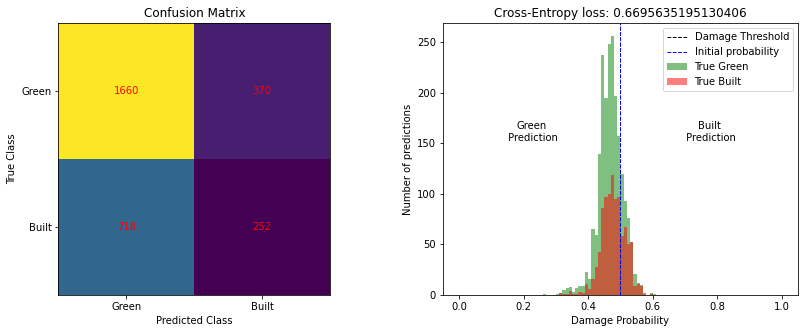

In [7]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, decisions, column='class')

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred, targets)

fig, axs = hf.create_subplots(1,2, figsize=[14,5])
# Confusion matrix
axs = hf.confusion_matrix(axs, y_true, yp_clf, classes)
  
# Cross entropy / Confidence metrics
axs = hf.cross_entropy_metrics(axs, y_true, y_pred, classes)

hf.show_plot()

In [8]:
# Save figure
hf.save_plot(fig, 'results/Houston_adj{}{}_ps{}{}_hs0_10000'.format(str(adjacent),str(geoNeighbours),str(phase),str(neighbours)))

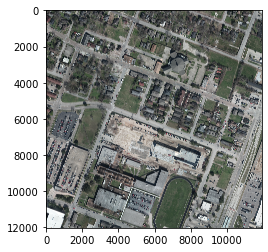

In [24]:
loc = '272056_3290290'
im = Image.open('./data/2018IEEE_Contest/Phase2/Final RGB HR Imagery/UH_NAD83_'+loc+'.tif')
plt.imshow(np.array(im))